### Spring 2025 ECG Analysis 

##### Modification: switched from rapidHRV to Systole for heart rate preprocessing & peak detection

In [140]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF

import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from scipy.stats import sem
from copy import copy as copy
import operator as operator

import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from functools import reduce

%pylab inline
figsize(5, 5)

import glob

import os
# Added to avoid OMP:error#15
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/var/folders/_k/84ry5gsj3bnd86w91nlcyck00000gr/T/ipykernel_48117/1845472488.py:13: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr # Pearson's correlation
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['copy', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [141]:
import pathlib
from ecgdetectors import Detectors
import sys
sampleRate = 100
fs = sampleRate
detectors = Detectors(sampleRate)


In [142]:
mergedDFClean = pd.read_csv("mergedPhysioAndBehav_Jan2025.csv")
# remove Unamed columns
mergedDFClean = mergedDFClean.loc[:, ~mergedDFClean.columns.str.contains('^Unnamed')]
mergedDFClean['PART_trial'] = mergedDFClean['partNum'].astype(str) + '_' + mergedDFClean['session'].astype(str) + '_' + mergedDFClean['trials'].astype(str)
mergedDFClean = mergedDFClean.dropna()

In [143]:
#screamOn: flagging trials where scream is presented; infoOn: flagging trials where information is chosen

mergedDFClean.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo', 'stimNoInfo', 'scream', 'noScream', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename', 'PART_trial'],
      dtype='object')

# separate signal by participant

# Preprocess data & detect r-peaks

### Use ECG Detectors (two average detector) for r-peak detection

In [144]:
###Uses two average detector for r peak detectino

def preprocess(delaydata):
    delayProcessed = pd.DataFrame()

    for participant in np.unique(delaydata['partNum']):
        dataPart = delaydata[delaydata['partNum'] == participant].copy()
        time =dataPart['time'].values
        signal = dataPart.EKG.values 
        r_peaks = detectors.pan_tompkins_detector(signal)
        peaks_mask = np.zeros_like(signal, dtype=bool)
        peaks_mask[r_peaks] = True

        dataPart['pEKG'] = signal #same as raw EKG value, changing the name for consistency purposes
        dataPart['peak'] = peaks_mask
        dataPart['peak_time'] = np.where(peaks_mask, time, np.nan)

        delayProcessed = pd.concat([delayProcessed, dataPart], ignore_index=True)

    return delayProcessed

# extract baseline using the start trial period (first 2 seconds)

In [145]:
def IBI_baseline(mergedDFClean):
    dataBaseline = mergedDFClean#.loc[(mergedDFClean['startTrial'] == 1)]
    dataBaseline0= preprocess(dataBaseline)

    ### create baseline IBI for each trial

    rows = []

    for participant in dataBaseline0['partNum'].unique():
        part_data = dataBaseline0[dataBaseline0['partNum'] == participant]
        for session in dataBaseline0['session'].unique():
            sess_data = part_data[part_data['session'] == session]
            
            for trial in sess_data['trials'].unique():
                trial_data = sess_data[sess_data['trials'] == trial]
                part_trial = trial_data['PART_trial'].iloc[0]
                delay      = trial_data['delay_time'].iloc[0]

                
                peak_idxs = np.where(trial_data['peak'])[0]        
                
                
                if len(peak_idxs) < 2:
                    mean_ibi = np.nan

                else:
                    ibi_samples = np.diff(peak_idxs)
                    mean_ibi = ibi_samples.mean()/ sampleRate

                rows.append({
                    'participant': participant,
                    'session': session,
                    'trial': trial,
                    'delay_time':  delay,
                    'baseline': mean_ibi,
                    'PART_trial': part_trial
                    
                })
            
    #return baseline_IBI
    baseline_IBI = pd.DataFrame(rows)

    
    return baseline_IBI


# Compute IBI intervals from before infochoice presentation till after stimulus presentation time

In [146]:
def compute_IBI (data,baseline_df):

    """
    Returns a DataFrame with one row per trial, containing:
      - participant, delay_time, PART_trial
      - IBIs: list of normalized IBIs (s)
      - time_norm: list of IBI timestamps relative to window start (s)
      - cue_norm, stim_norm: cue and stim onsets relative to window start (s)
      *** remove outliers with IBI values > 2 (some trials have recording issues)
    """
    rows = []

    for trials in data['PART_trial'].unique():
        trial_data = data[data['PART_trial']==trials]
        participant = trial_data['partNum'].iloc[0]
        delay = trial_data['delay_time'].iloc[0]

        #extract time point stimInfo or stimNoInfo is presented
        if 'stimInfoOnset' in trial_data.columns and trial_data['stimInfoOnset'].eq(1).any():
            cueTime = trial_data.loc[trial_data['stimInfoOnset']==1, 'time'].iloc[0]
        elif 'stimNoInfoOnset' in trial_data.columns and trial_data['stimNoInfoOnset'].eq(1).any():
            cueTime = trial_data.loc[trial_data['stimNoInfoOnset']==1, 'time'].iloc[0]
        else:
            cueTime = np.nan

        #extract time point scream or noScream is presented
        if 'screamOnset' in trial_data.columns and trial_data['screamOnset'].eq(1).any():
            stimTime = trial_data.loc[trial_data['screamOnset']==1,'time'].iloc[0]
        elif 'noScreamOnset' in trial_data.columns and trial_data['noScreamOnset'].eq(1).any():
            stimTime = trial_data.loc[trial_data['noScreamOnset']==1,'time'].iloc[0]    
        else:
            stimTime = np.nan

        #define start and end time of where ibi values will be extracted
        pre_window = 2.0 #adding 2 sec before infocue onset
        post_window = 2.0 #adding 2 sec after outcome stimulus presentation
        start = cueTime - pre_window
        end = stimTime + post_window

        
        # restrict to peaks in that window
        peak_times = trial_data.loc[trial_data['peak']==1, 'time'].values
        in_window = peak_times[(peak_times >= start) & (peak_times <= end)]
        if len(in_window) < 2:
            continue
        
        #compute raw and normalized ibis
        ibis      = np.diff(in_window)
        ibi_times = (in_window[:-1] + in_window[1:]) / 2

        # —— REMOVE OUTLIERS: drop any IBI > 2 seconds —— 
        mask = ibis < 2.0
        ibis = ibis[mask]
        ibi_times = ibi_times[mask]
        if len(ibis) == 0:
            # nothing left after filtering
            continue

        # —— normalize time to window start —— 
        t_norm     = (ibi_times - start).tolist()
        cue_norm   = cueTime   - start
        stim_norm  = stimTime  - start

        base       = baseline_df.loc[
                         baseline_df['PART_trial']==trials,'baseline'
                     ].iloc[0]
        ibis_norm  = (ibis - base).tolist()

        
        # get this trial’s delay_time (or whatever column you have)
        delay = trial_data['delay_time'].iloc[0]

        
        # collect one row per IBI
        rows.append({
            'participant': participant,
            'delay_time':  delay,
            'PART_trial':  trials,
            'IBIs':        ibis_norm,
            'time_norm':   t_norm,
            'cue_norm':    cue_norm,
            'stim_norm':   stim_norm
        })
        
    return pd.DataFrame(rows)

        
    

In [147]:
import numpy as np
import pandas as pd

def avg_IBI(trial_df,baseline_df):
    """
    From trial_df (output of compute_IBI), compute:
      1) per‐trial mean IBI between infoOnset and stimOnset
      2) per‐participant x delay mean of those trial means
      3) per‐delay mean across participants.

    Returns
    -------
    part_delay_df : DataFrame with columns
        participant, delay_time, mean_IBI
    delay_df : DataFrame with columns
        delay_time, mean_IBI_across_participants
    """
    # 1) compute per‐trial means
    trial_means = []
    for _, row in trial_df.iterrows():
        ibis  = row['IBIs']
        times = row['time_norm']
        c, s  = row['cue_norm'], row['stim_norm']
        # select only the IBIs whose midpoint lies between cue and stim
        sel   = [ibi for ibi, t in zip(ibis, times) if c <= t <= s]
        if not sel:
            continue

        mean_norm    = np.mean(sel)
        baseline     = baseline_df.loc[
                           baseline_df['PART_trial']==row['PART_trial'],
                           'baseline'
                       ].iloc[0]
        mean_raw     = mean_norm + baseline

        trial_means.append({
            'participant': row['participant'],
            'delay_time':  row['delay_time'],
            'mean_IBI':    mean_raw
        })

    trial_df2 = pd.DataFrame(trial_means)

    # 2) average by participant x delay
    part_delay_df = (
        trial_df2
        .groupby(['participant','delay_time'], as_index=False)
        ['mean_IBI']
        .mean()
    )

    # 3) average across participants, per delay
    delay_df = (
        part_delay_df
        .groupby('delay_time', as_index=False)
        ['mean_IBI']
        .mean()
    )

    return part_delay_df, delay_df


In [167]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_change_dots_with_error(
    baseline1, baseline2, baseline3,
    raw_part1, raw_part2, raw_part3,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
):
    """
    Plot paired baseline vs. raw dots with error bars for each condition,
    one figure per delay.

    baseline ibi value vs. average ibi value during the entire delay period 

    Parameters
    ----------
    baselineX : pd.DataFrame with columns ['participant','delay_time','baseline']
        Trial-level baseline IBIs.
    raw_partX : pd.DataFrame with columns ['participant','delay_time','mean_IBI']
        Participant-level raw IBI means (first output of avg_IBI).
    cond_labels : tuple of 3 condition names in the order of dataframes.
    """
    # --- Summarize baseline: trials→participant→delay ---
    def summarize_baseline(df, label):
        part = df.groupby(['participant','delay_time'], as_index=False)['baseline'].mean()
        stats = part.groupby('delay_time')['baseline'].agg(['mean','std','count']).reset_index()
        stats['sem'] = stats.apply(
            lambda r: (r['std'] / np.sqrt(r['count'])) if r['count'] >= 2 else 0.0,
            axis=1
        )
        stats = stats.rename(columns={'mean': f'{label}_mean', 'sem': f'{label}_sem'})
        print(stats)
        return stats[['delay_time', f'{label}_mean', f'{label}_sem']]

    # --- Summarize raw: participant→delay ---
    def summarize_raw_part(df, label):
        part = df.groupby(['participant','delay_time'], as_index=False)['mean_IBI'].mean()
        stats = part.groupby('delay_time')['mean_IBI'].agg(['mean','std','count']).reset_index()
        stats['sem'] = stats.apply(
            lambda r: (r['std'] / np.sqrt(r['count'])) if r['count'] >= 2 else 0.0,
            axis=1
        )
        stats = stats.rename(columns={'mean': f'{label}_raw_mean', 'sem': f'{label}_raw_sem'})
        print(stats)
        return stats[['delay_time', f'{label}_raw_mean', f'{label}_raw_sem']]

    # baseline summaries
    b1 = summarize_baseline(baseline1, cond_labels[0])
    b2 = summarize_baseline(baseline2, cond_labels[1])
    b3 = summarize_baseline(baseline3, cond_labels[2])
    # raw summaries at participant level
    r1 = summarize_raw_part(raw_part1, cond_labels[0])
    r2 = summarize_raw_part(raw_part2, cond_labels[1])
    r3 = summarize_raw_part(raw_part3, cond_labels[2])

    # merge all on delay_time
    merged = b1.merge(b2, on='delay_time').merge(b3, on='delay_time')
    merged = merged.merge(r1, on='delay_time').merge(r2, on='delay_time').merge(r3, on='delay_time')


    # plotting
    x = np.arange(len(cond_labels))
    offset = 0.05
    for _, row in merged.iterrows():
        delay = row['delay_time']
        base_means = [row[f'{c}_mean'] for c in cond_labels]
        base_sems  = [row[f'{c}_sem']  for c in cond_labels]
        raw_means  = [row[f'{c}_raw_mean'] for c in cond_labels]
        raw_sems   = [row[f'{c}_raw_sem']  for c in cond_labels]

        fig, ax = plt.subplots(figsize=(6,4))
        ax.errorbar(x - offset, base_means, yerr=base_sems,
                    fmt='o', color='C0', label='Baseline', capsize=4)
        ax.errorbar(x + offset, raw_means, yerr=raw_sems,
                    fmt='o', color='C1', label='Raw', capsize=4)
        for xi, b, r in zip(x, base_means, raw_means):
            ax.plot([xi - offset, xi + offset], [b, r],
                    color='gray', linestyle='--', linewidth=1)

        ax.set_xticks(x)
        ax.set_xticklabels(cond_labels)
        ax.set_xlabel('Condition')
        ax.set_ylabel('Mean IBI (s)')
        ax.set_title(f'Change Baseline→Anticipation IBI — Delay {delay}s')
        ax.legend()
        ax.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.show()

    return merged


In [ ]:
def plot_ibi_diff(
    baseline1, baseline2, baseline3,
    raw_part1, raw_part2, raw_part3,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
):
    """
    Plot diff values between baseline and averaged raw ibis for each condition,
    one figure per delay.

    """

    val1 = 

# Implement Functions with data
##### 1. prepocess all data to obtain peak information
##### For the following steps, data is categorized into three main parts: information scream, information no scream, no information
##### 2. compute baseline values for each data cateory
##### 3. compute normalized ibi values
##### 4.(1). compute average ibi values by averaging across trials spanning anticipation (delay) time, separated by delay time
##### 4.(2). pick one beat prior to infoCue onset and three beats after the onset, then average across trials, separated by delay time

In [149]:
#preprocess all data to obtain peak values
processed_all = preprocess(mergedDFClean)


In [150]:
processed_all.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo', 'stimNoInfo', 'scream', 'noScream', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename', 'PART_trial', 'pEKG', 'peak', 'peak_time'],
      dtype='object')

In [151]:
#compute baseline values for stimInfo_scream, stimInfo_noScream, and stimNoinfo
baseline_IBI_stimInfo_scream= IBI_baseline(processed_all.loc[(processed_all['startTrial'] == 1)& (processed_all['screamOn'] == 1) & (processed_all['infoOn'] == 1) ])
baseine_IBI_stimInfo_noScream = IBI_baseline(processed_all.loc[(processed_all['startTrial'] == 1)& (processed_all['screamOn'] == 0) & (processed_all['infoOn'] == 1) ])
baseine_IBI_stimNoInfo = IBI_baseline(processed_all.loc[(processed_all['startTrial'] == 1)& (processed_all['infoOn'] == 0) ])


In [152]:
# extract all data for stimInfo_scream, stimInfo_noScream, and stimNoinfo
stimInfo_scream_df = processed_all[(processed_all['screamOn']==1)&(processed_all['infoOn']==1)] 
stimInfo_noScream_df = processed_all[(processed_all['screamOn']==0) & (processed_all['infoOn']==1)]
stimNoInfo_df = processed_all[(processed_all['infoOn']==0)]

In [153]:
#compute ibi values for all data
stimInfo_scream_ibis = compute_IBI(stimInfo_scream_df,baseline_IBI_stimInfo_scream)
stimInfo_noScream_ibis = compute_IBI(stimInfo_noScream_df,baseine_IBI_stimInfo_noScream)
stimNoInfo_ibis = compute_IBI(stimNoInfo_df,baseine_IBI_stimNoInfo)

In [154]:
stimInfo_scream_ibis[(stimInfo_scream_ibis['participant']==130)&(stimInfo_scream_ibis['delay_time']==40)]['IBIs']

1317    [-0.03000000001746228, -0.15999999999301506, -...
1319    [0.005714285727091428, 0.035714285696823445, 0...
1320    [0.06428571428571428, -0.0057142856921668095, ...
Name: IBIs, dtype: object

In [156]:
processed_all[processed_all['PART_trial']=='130_2_8']

,PART_x,EKG,EDA,startBlock,startTrial,infoChoice,stimInfo,stimNoInfo,scream,noScream,...,delay_time,choice_keys,prob,screamOn,infoOn,filename,PART_trial,pEKG,peak,peak_time
11934582,P130_Aversive,-0.128967,0.521850,0,1,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,-0.128967,False,NaN
11934583,P130_Aversive,0.324707,0.520324,0,1,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,0.324707,False,NaN
11934584,P130_Aversive,1.289000,0.520324,0,1,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,1.289000,False,NaN
11934585,P130_Aversive,1.039250,0.524902,0,1,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,1.039250,False,NaN
11934586,P130_Aversive,-0.160645,0.524902,0,1,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,-0.160645,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11937220,P130_Aversive,0.139038,0.740051,0,0,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,0.139038,False,NaN
11937221,P130_Aversive,0.188660,0.736999,0,0,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,0.188660,False,NaN
11937222,P130_Aversive,0.238159,0.744628,0,0,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,0.238159,False,NaN
11937223,P130_Aversive,0.303528,0.741577,0,0,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,0.303528,False,NaN


In [159]:
part_avg_stimInfo_scream,avg_stimInfo_scream = avg_IBI(stimInfo_scream_ibis,baseline_IBI_stimInfo_scream)
part_avg_stimInfo_noScream,avg_stimInfo_noScream = avg_IBI(stimInfo_noScream_ibis,baseine_IBI_stimInfo_noScream)
part_avg_stimNoInfo, avg_stimNoInfo = avg_IBI(stimNoInfo_ibis,baseine_IBI_stimNoInfo)

In [160]:
part_avg_stimNoInfo

,participant,delay_time,mean_IBI
0,44,2.0,0.707778
1,44,5.0,0.722364
2,44,10.0,0.710860
3,44,20.0,0.700809
4,44,40.0,0.723383
...,...,...,...
201,132,2.0,0.857115
202,132,5.0,0.821965
203,132,10.0,0.811309
204,132,20.0,0.803259


In [161]:
avg_stimInfo_scream

,delay_time,mean_IBI
0,2.0,0.827761
1,5.0,0.818636
2,10.0,0.823308
3,20.0,0.826277
4,40.0,0.819567


In [162]:
avg_stimInfo_scream

,delay_time,mean_IBI
0,2.0,0.827761
1,5.0,0.818636
2,10.0,0.823308
3,20.0,0.826277
4,40.0,0.819567


   delay_time  Info+Scream_mean       std  count  Info+Scream_sem
0         2.0          0.848511  0.122329     44         0.018442
1         5.0          0.851248  0.111028     42         0.017132
2        10.0          0.847540  0.120387     45         0.017946
3        20.0          0.848823  0.118183     45         0.017618
4        40.0          0.830030  0.117146     37         0.019259
   delay_time  Info+NoScream_mean       std  count  Info+NoScream_sem
0         2.0            0.847331  0.168848     44           0.025455
1         5.0            0.846116  0.128864     44           0.019427
2        10.0            0.832871  0.109850     44           0.016561
3        20.0            0.834152  0.117058     44           0.017647
4        40.0            0.817477  0.099203     38           0.016093
   delay_time  NoInfo_mean       std  count  NoInfo_sem
0         2.0     0.842476  0.106368     43    0.016221
1         5.0     0.830431  0.112165     43    0.017105
2        10.0   

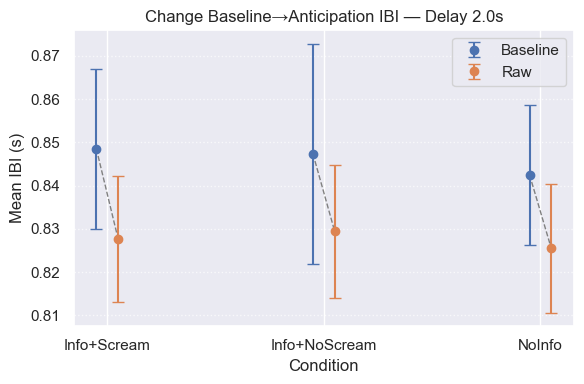

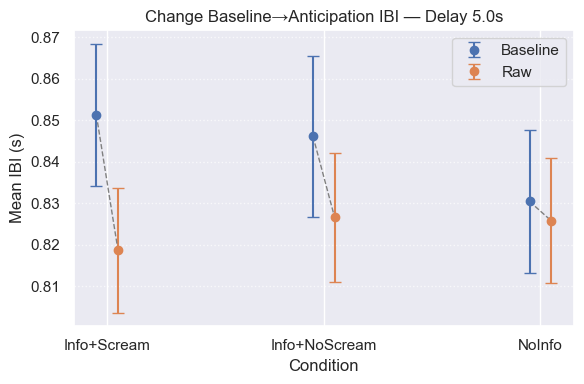

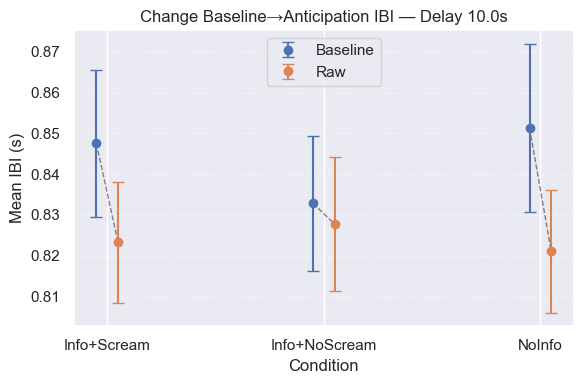

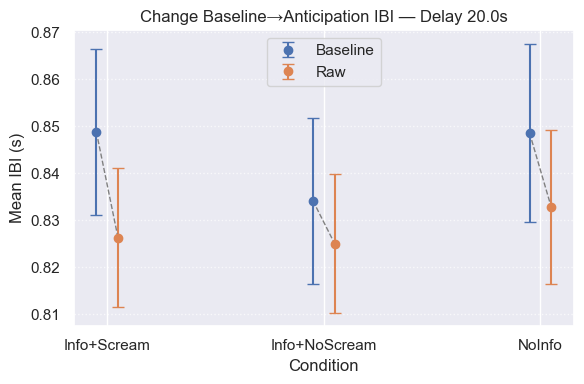

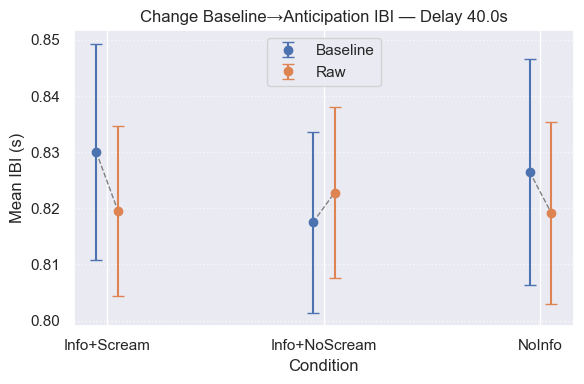

In [168]:
summary_ibi= plot_change_dots_with_error(
    baseline_IBI_stimInfo_scream,
    baseine_IBI_stimInfo_noScream,
    baseine_IBI_stimNoInfo,
    part_avg_stimInfo_scream,
    part_avg_stimInfo_noScream,
    part_avg_stimNoInfo,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
)

In [164]:
def plot_change_dots_with_error(
    baseline1, baseline2, baseline3,
    raw_part1, raw_part2, raw_part3,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
):
    """
    Plot paired baseline vs. raw dots with error bars for each condition,
    one figure per delay.

    Parameters
    ----------
    baselineX : pd.DataFrame with columns ['participant','delay_time','baseline']
        Trial-level baseline IBIs.
    raw_partX : pd.DataFrame with columns ['participant','delay_time','mean_IBI']
        Participant-level raw IBI means (first output of avg_IBI).
    cond_labels : tuple of 3 condition names in the order of dataframes.
    """
    # --- Summarize baseline: trials→participant→delay ---
    def summarize_baseline(df, label):
        part = df.groupby(['participant','delay_time'], as_index=False)['baseline'].mean()
        stats = part.groupby('delay_time')['baseline'].agg(['mean','std','count']).reset_index()
        stats['sem'] = stats.apply(
            lambda r: (r['std'] / np.sqrt(r['count'])) if r['count'] >= 2 else 0.0,
            axis=1
        )
        stats = stats.rename(columns={'mean': f'{label}_mean', 'sem': f'{label}_sem'})
        print(stats)
        return stats[['delay_time', f'{label}_mean', f'{label}_sem']]

    # --- Summarize raw: participant→delay ---
    def summarize_raw_part(df, label):
        part = df.groupby(['participant','delay_time'], as_index=False)['mean_IBI'].mean()
        stats = part.groupby('delay_time')['mean_IBI'].agg(['mean','std','count']).reset_index()
        stats['sem'] = stats.apply(
            lambda r: (r['std'] / np.sqrt(r['count'])) if r['count'] >= 2 else 0.0,
            axis=1
        )
        stats = stats.rename(columns={'mean': f'{label}_raw_mean', 'sem': f'{label}_raw_sem'})
        print(stats)
        return stats[['delay_time', f'{label}_raw_mean', f'{label}_raw_sem']]

    # baseline summaries
    b1 = summarize_baseline(baseline1, cond_labels[0])
    b2 = summarize_baseline(baseline2, cond_labels[1])
    b3 = summarize_baseline(baseline3, cond_labels[2])
    # raw summaries at participant level
    r1 = summarize_raw_part(raw_part1, cond_labels[0])
    r2 = summarize_raw_part(raw_part2, cond_labels[1])
    r3 = summarize_raw_part(raw_part3, cond_labels[2])

    # merge all on delay_time
    merged = b1.merge(b2, on='delay_time').merge(b3, on='delay_time')
    merged = merged.merge(r1, on='delay_time').merge(r2, on='delay_time').merge(r3, on='delay_time')

    # plotting
    x = np.arange(len(cond_labels))
    offset = 0.15
    widths = 0.25

    for _, row in merged.iterrows():
        delay = row['delay_time']

        # collect the raw arrays for this delay
        base_data = [
            baseline1.loc[baseline1['delay_time']==delay, 'baseline'],
            baseline2.loc[baseline2['delay_time']==delay, 'baseline'],
            baseline3.loc[baseline3['delay_time']==delay, 'baseline'],
        ]
        raw_data = [
            raw_part1.loc[raw_part1['delay_time']==delay, 'mean_IBI'],
            raw_part2.loc[raw_part2['delay_time']==delay, 'mean_IBI'],
            raw_part3.loc[raw_part3['delay_time']==delay, 'mean_IBI'],
        ]

        fig, ax = plt.subplots(figsize=(6,4))

        # boxplots for baseline (blue) & raw (orange)
        bp1 = ax.boxplot(
            base_data,
            positions = x - offset,
            widths    = widths,
            patch_artist=True,
            boxprops  = dict(facecolor='C0', alpha=0.3),
            medianprops=dict(color='C0'),
            whiskerprops=dict(color='C0'),
            capprops   =dict(color='C0'),
            flierprops =dict(markeredgecolor='C0')
        )
        bp2 = ax.boxplot(
            raw_data,
            positions = x + offset,
            widths    = widths,
            patch_artist=True,
            boxprops  = dict(facecolor='C1', alpha=0.3),
            medianprops=dict(color='C1'),
            whiskerprops=dict(color='C1'),
            capprops   =dict(color='C1'),
            flierprops =dict(markeredgecolor='C1')
        )

        # overlay the means as dots if you like
        base_means = [row[f'{c}_mean'] for c in cond_labels]
        raw_means  = [row[f'{c}_raw_mean'] for c in cond_labels]
        ax.scatter(x - offset, base_means, color='C0', s=50, zorder=3)
        ax.scatter(x + offset, raw_means,  color='C1', s=50, zorder=3)

        ax.set_xticks(x)
        ax.set_xticklabels(cond_labels)
        ax.set_xlabel('Condition')
        ax.set_ylabel('Mean IBI (s)')
        ax.set_title(f'Change Baseline→Raw IBI — Delay {delay}s')

        # legend hack
        ax.plot([], [], color='C0', label='Baseline')
        ax.plot([], [], color='C1', label='Raw')
        ax.legend()

        ax.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.show()


   delay_time  Info+Scream_mean       std  count  Info+Scream_sem
0         2.0          0.848511  0.122329     44         0.018442
1         5.0          0.851248  0.111028     42         0.017132
2        10.0          0.847540  0.120387     45         0.017946
3        20.0          0.848823  0.118183     45         0.017618
4        40.0          0.830030  0.117146     37         0.019259
   delay_time  Info+NoScream_mean       std  count  Info+NoScream_sem
0         2.0            0.847331  0.168848     44           0.025455
1         5.0            0.846116  0.128864     44           0.019427
2        10.0            0.832871  0.109850     44           0.016561
3        20.0            0.834152  0.117058     44           0.017647
4        40.0            0.817477  0.099203     38           0.016093
   delay_time  NoInfo_mean       std  count  NoInfo_sem
0         2.0     0.842476  0.106368     43    0.016221
1         5.0     0.830431  0.112165     43    0.017105
2        10.0   

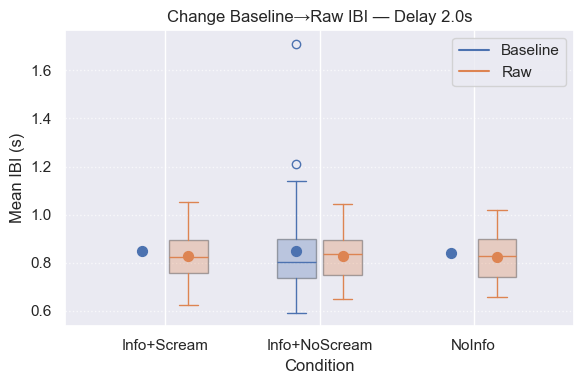

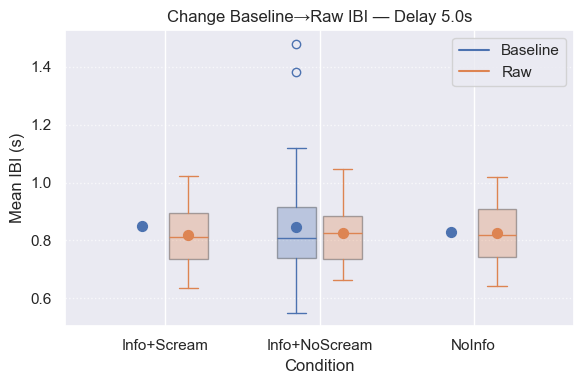

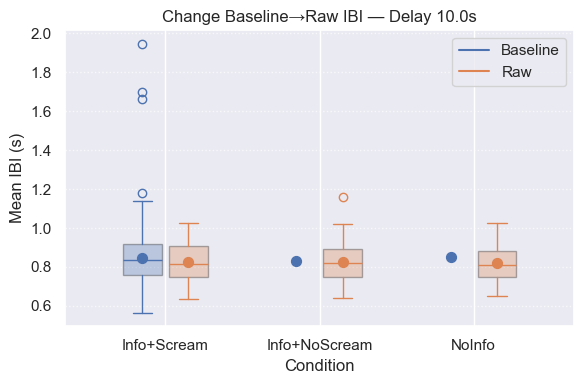

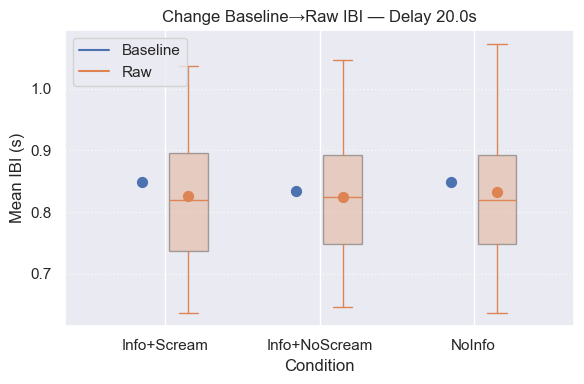

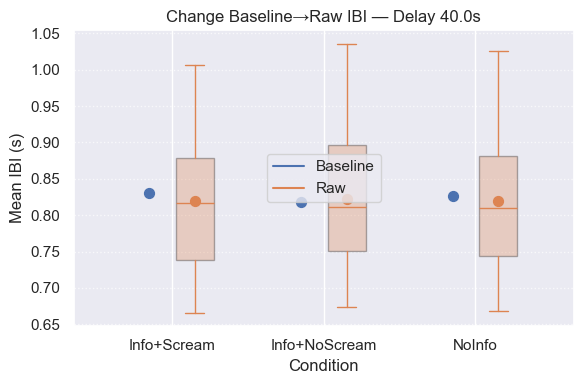

In [165]:
plot_change_dots_with_error(
    baseline_IBI_stimInfo_scream,
    baseine_IBI_stimInfo_noScream,
    baseine_IBI_stimNoInfo,
    part_avg_stimInfo_scream,
    part_avg_stimInfo_noScream,
    part_avg_stimNoInfo,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
)

In [169]:
summary_ibi

,delay_time,Info+Scream_mean,Info+Scream_sem,Info+NoScream_mean,Info+NoScream_sem,NoInfo_mean,NoInfo_sem,Info+Scream_raw_mean,Info+Scream_raw_sem,Info+NoScream_raw_mean,Info+NoScream_raw_sem,NoInfo_raw_mean,NoInfo_raw_sem
0,2.0,0.848511,0.018442,0.847331,0.025455,0.842476,0.016221,0.827761,0.014580,0.829471,0.015388,0.825503,0.014909
1,5.0,0.851248,0.017132,0.846116,0.019427,0.830431,0.017105,0.818636,0.015014,0.826586,0.015585,0.825774,0.015083
2,10.0,0.847540,0.017946,0.832871,0.016561,0.851281,0.020654,0.823308,0.014794,0.827723,0.016444,0.821064,0.015039
3,20.0,0.848823,0.017618,0.834152,0.017647,0.848577,0.018991,0.826277,0.014829,0.825031,0.014725,0.832794,0.016351
4,40.0,0.830030,0.019259,0.817477,0.016093,0.826500,0.020157,0.819567,0.015157,0.822782,0.015195,0.819179,0.016229


# Check Data